In [2]:
import os
import numpy as np
import pandas as pd
import uproot
import awkward as ak
import matplotlib.pyplot as plt
import seaborn as sns
import vector
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
import xgboost as xgb
import joblib
from glob import glob

# Load ROOT files (periods A-K)

In [3]:
root_file = sorted(glob("ATLAS_data/ODEO_FEB2025_v0_2J2LMET30_data*_period*.2J2LMET30.root")) 

In [4]:
arrays = uproot.concatenate(
    {f: "analysis" for f in root_file},
    [
        "lep_pt", "lep_eta", "lep_phi", "lep_e",
        "jet_pt", "jet_eta", "jet_phi", "jet_e", "jet_btag_quantile",
        "met", "met_phi"
    ]
)
print("Events loaded:", len(arrays))

Events loaded: 6242521


In [5]:
files = uproot.open("ATLAS_data/ODEO_FEB2025_v0_2J2LMET30_data15_periodD.2J2LMET30.root")
print(files.keys())
tree = files["analysis"]
print(tree.keys())

['analysis;1']
['num_events', 'sum_of_weights', 'sum_of_weights_squared', 'category', 'sig_lep', 'n_sig_lep', 'TriggerMatch_DILEPTON', 'ScaleFactor_MLTRIGGER', 'ScaleFactor_PILEUP', 'ScaleFactor_FTAG', 'mcWeight', 'xsec', 'filteff', 'kfac', 'channelNumber', 'eventNumber', 'runNumber', 'trigML', 'trigP', 'trigDT', 'trigT', 'trigE', 'trigDM', 'trigDE', 'trigM', 'trigMET', 'ScaleFactor_BTAG', 'ScaleFactor_JVT', 'jet_n', 'jet_pt', 'jet_eta', 'jet_phi', 'jet_e', 'jet_btag_quantile', 'jet_jvt', 'largeRJet_n', 'largeRJet_pt', 'largeRJet_eta', 'largeRJet_phi', 'largeRJet_e', 'largeRJet_m', 'largeRJet_D2', 'jet_pt_jer1', 'jet_pt_jer2', 'ScaleFactor_ELE', 'ScaleFactor_MUON', 'ScaleFactor_LepTRIGGER', 'ScaleFactor_MuTRIGGER', 'ScaleFactor_ElTRIGGER', 'lep_n', 'lep_type', 'lep_pt', 'lep_eta', 'lep_phi', 'lep_e', 'lep_charge', 'lep_ptvarcone30', 'lep_topoetcone20', 'lep_z0', 'lep_d0', 'lep_d0sig', 'lep_isTightID', 'lep_isMediumID', 'lep_isLooseID', 'lep_isTightIso', 'lep_isLooseIso', 'lep_isTrigMat

# Preselection type 2J2L MET>30

In [6]:
mask = (ak.num(arrays["lep_pt"]) == 2) & (ak.num(arrays["jet_pt"]) >= 2) & (arrays["met"] > 30)
arrays_sel = arrays[mask]
print("Events following pre-selection:", len(arrays_sel))


Events following pre-selection: 5652084


# Create 4-vectors and calculate variables

In [7]:
vector.register_awkward()

lep = ak.zip({
    "pt": arrays_sel["lep_pt"],
    "eta": arrays_sel["lep_eta"],
    "phi": arrays_sel["lep_phi"],
    "E": arrays_sel["lep_e"]
}, with_name="Momentum4D")

jet = ak.zip({
    "pt": arrays_sel["jet_pt"],
    "eta": arrays_sel["jet_eta"],
    "phi": arrays_sel["jet_phi"],
    "E": arrays_sel["jet_e"]
}, with_name="Momentum4D")

# dileptonic invariant mass
m_ll = (lep[:,0] + lep[:,1]).mass

# ΔR  between leptons
dR_ll = lep[:,0].deltaR(lep[:,1])

# Variables of jets
n_jets = ak.num(jet)
n_bjets = ak.sum(arrays_sel["jet_btag_quantile"] > 0.5, axis=1)

# HT y Meff
ht = ak.sum(jet.pt, axis=1)
meff = ht + ak.sum(lep.pt, axis=1) + arrays_sel["met"]

# leading jets
j1_pt = jet[:,0].pt
j2_pt = jet[:,1].pt

# Build DataFrame for analysis

In [8]:
df = pd.DataFrame({
    "m_ll": ak.to_numpy(m_ll),
    "met": ak.to_numpy(arrays_sel["met"]),
    "n_jets": ak.to_numpy(n_jets),
    "n_bjets": ak.to_numpy(n_bjets),
    "ht": ak.to_numpy(ht),
    "meff": ak.to_numpy(meff),
    "dR_ll": ak.to_numpy(dR_ll),
    "j1_pt": ak.to_numpy(j1_pt),
    "j2_pt": ak.to_numpy(j2_pt)
})

df.head()


,m_ll,met,n_jets,n_bjets,ht,meff,dR_ll,j1_pt,j2_pt
0,98.786705,32.000393,3,3,129.124786,265.388092,2.447582,45.529007,44.244377
1,0.954021,41.463879,2,2,42.722340,121.041031,0.060582,20.359121,22.363218
2,2.428268,49.653851,3,3,268.306274,337.478180,0.248110,140.996841,87.729790
3,19.196783,39.204754,2,2,48.385006,104.703308,3.193857,26.345266,22.039740
4,3.124062,37.127811,2,2,67.595627,137.213333,0.217480,41.679920,25.915710


# Basic distributions

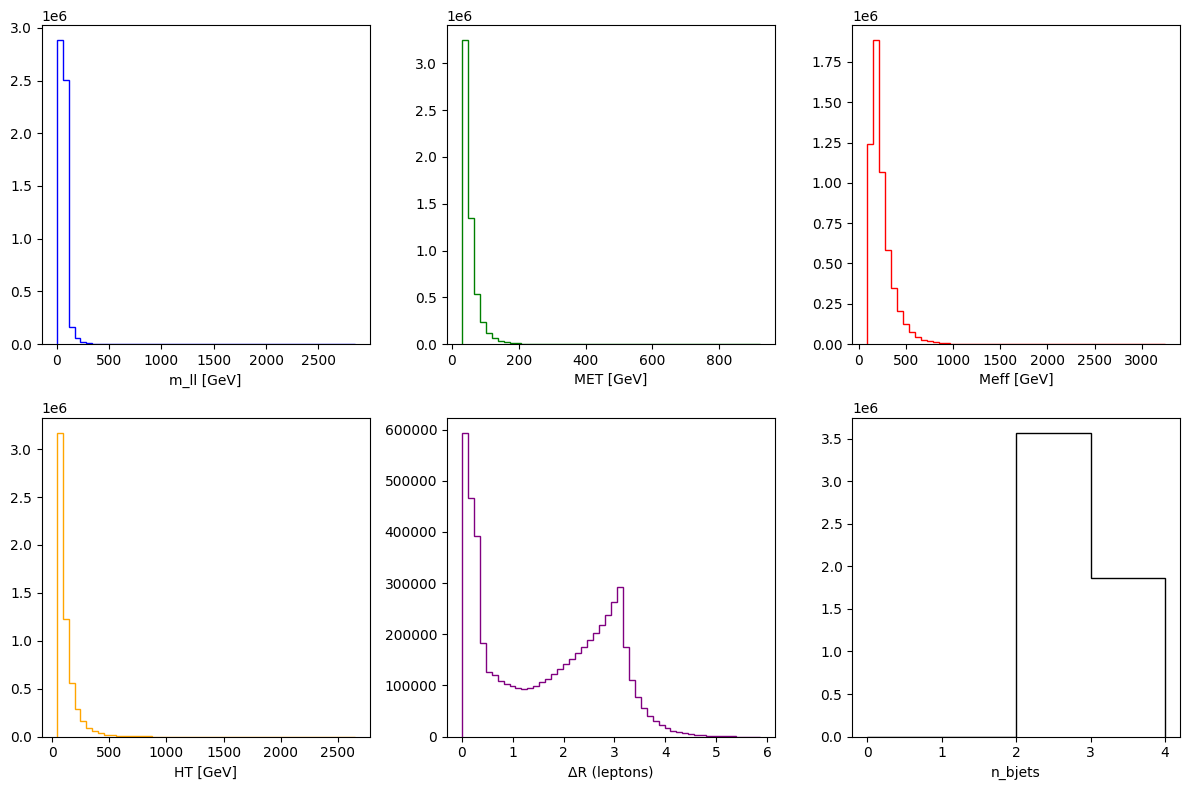

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(12,8))
axes = axes.flatten()

axes[0].hist(df["m_ll"], bins=50, histtype="step", color="blue")
axes[0].set_xlabel("m_ll [GeV]")

axes[1].hist(df["met"], bins=50, histtype="step", color="green")
axes[1].set_xlabel("MET [GeV]")

axes[2].hist(df["meff"], bins=50, histtype="step", color="red")
axes[2].set_xlabel("Meff [GeV]")

axes[3].hist(df["ht"], bins=50, histtype="step", color="orange")
axes[3].set_xlabel("HT [GeV]")

axes[4].hist(df["dR_ll"], bins=50, histtype="step", color="purple")
axes[4].set_xlabel("ΔR (leptons)")

axes[5].hist(df["n_bjets"], bins=[0,1,2,3,4], histtype="step", color="black")
axes[5].set_xlabel("n_bjets")

plt.tight_layout()
plt.show()


# Filtered by regions of interest

In [10]:
# Control "Z" region (background)
region_Z = (df["m_ll"] > 80) & (df["m_ll"] < 100)

# Region of Interest SUSY (Hight MET, Hight Meff)
region_SUSY = (df["met"] > 150) & (df["meff"] > 1000)

print("Events Z region:", np.sum(region_Z))
print("Events SUSY-like:", np.sum(region_SUSY))


Events Z region: 2033529
Events SUSY-like: 2575


# Display Z vs SUSY contrast

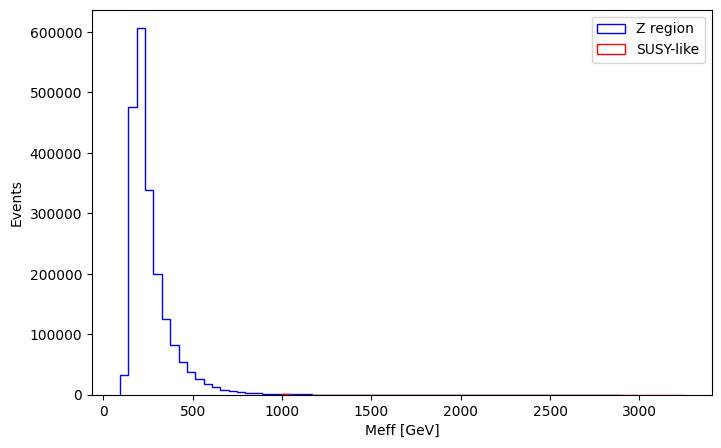

In [11]:
plt.figure(figsize=(8,5))
plt.hist(df["meff"][region_Z], bins=60, histtype="step", color="blue", label="Z region")
plt.hist(df["meff"][region_SUSY], bins=60, histtype="step", color="red", label="SUSY-like")
plt.xlabel("Meff [GeV]")
plt.ylabel("Events")
plt.legend()
plt.show()


# Save processed dataset

In [12]:
df.to_csv("atlas_2J2LMET30_processed.csv", index=False)
print("File CSV Saved.")


File CSV Saved.


# (Optional) Summary statistics

In [13]:
print(df.describe())

               m_ll           met        n_jets       n_bjets            ht  \
count  5.652084e+06  5.652084e+06  5.652084e+06  5.652084e+06  5.652084e+06   
mean   5.389265e+01  5.248854e+01  2.550815e+00  2.550815e+00  1.130930e+02   
std    5.074412e+01  2.605402e+01  8.777221e-01  8.777221e-01  8.849181e+01   
min   -1.000000e+00  3.000000e+01  2.000000e+00  2.000000e+00  4.000844e+01   
25%    4.358003e+00  3.610141e+01  2.000000e+00  2.000000e+00  5.667536e+01   
50%    5.217056e+01  4.449343e+01  2.000000e+00  2.000000e+00  8.319263e+01   
75%    9.061056e+01  5.920283e+01  3.000000e+00  3.000000e+00  1.345348e+02   
max    2.845972e+03  9.215549e+02  1.400000e+01  1.400000e+01  2.646858e+03   

               meff         dR_ll         j1_pt         j2_pt  
count  5.652084e+06  5.652084e+06  5.652084e+06  5.652084e+06  
mean   2.365825e+02  1.671297e+00  6.158982e+01  3.554418e+01  
std    1.262419e+02  1.219510e+00  5.053142e+01  2.592341e+01  
min    8.539335e+01  0.000000e+0